In [1]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "reciprocate/dahoas-gptj-rm-static"
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

/root/new/sae-rm/rm_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]/root/new/sae-rm/rm_env/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Loading checkpoint shards: 100%|██████████| 3/3 [00:11<00:00,  3.69s/it]


In [2]:
from huggingface_hub import hf_hub_download
from dictionary import GatedAutoEncoder

# import sys
# sys.path.append("/root/dictionary_learning/")

layer = 14
activation_name = f"transformer.h.{layer}"
model_id = "Elriggs/rm"
sae_file_save_name = f"ae_layer{layer}"
sae_filename = sae_file_save_name + ".pt"
sae_file_dir = f"sae_results/{sae_file_save_name}"
ae_download_location = hf_hub_download(repo_id=model_id, filename=sae_filename)
# all_autoencoders = torch.load(ae_download_location)

# Download Effect Dataset
token_length_cutoff = 500
top = 2000
dataset_id = "Elriggs/rm_effects"
filename = f'ae_layer{layer}/all_effects_per_feature_token_{token_length_cutoff}_top_{top}.pt'
download_location = hf_hub_download(repo_id=dataset_id, filename=filename, repo_type = "dataset")
all_effects = torch.load(download_location)
# filename = f"sae_results/ae_layer{layer}/all_effects_per_feature_chosen_token_{token_length_cutoff}_top_{top}.pt"
# chosen_effects = torch.load(filename)
# filename = f"sae_results/ae_layer{layer}/all_effects_per_feature_rejected_token_{token_length_cutoff}_top_{top}.pt"
# rejected_effects = torch.load(filename)
# data_points, num_features = chosen_effects.shape
# all_effects = torch.zeros(data_points*2, num_features)
# all_effects[::2] = chosen_effects
# all_effects[1::2] = rejected_effects
sae = GatedAutoEncoder.from_pretrained(ae_download_location).to(device)

In [3]:
def separate_interleaved(tensor, step):
    chosen_list = []
    rejected_list = []
    
    for i in range(0, len(tensor), 2 * step):
        chosen_list.extend(tensor[i:i + step].tolist())
        rejected_list.extend(tensor[i + step:i + 2 * step].tolist())
        
    return torch.tensor(chosen_list), torch.tensor(rejected_list)

# Fix my indexing error
chosen_effects, rejected_effects = separate_interleaved(all_effects, 2)

In [4]:
data_points, num_features = chosen_effects.shape
all_effects = torch.zeros(data_points*2, num_features)
all_effects[::2] = chosen_effects
all_effects[1::2] = rejected_effects

In [5]:
# sae_file_save_name = sae_file.split("/")[1].split(".")[0]
sae_file_dir = f"sae_results/{sae_file_save_name}"

In [6]:
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import torch 
from datasets import Dataset
hh = load_dataset("Anthropic/hh-rlhf", split="train")

# (1) Filter by token length (ie < 500 tokens)
hh_ind_short_enough_filepath = f"rm_save_files/hh_ind_lower_than_{token_length_cutoff}_tokens.pt"
index_small_enough = torch.load(hh_ind_short_enough_filepath)

# (2) Filter by Reward Difference
# dataset_size = len(hh)
top_reward_filename = f"rm_save_files/token_len_{token_length_cutoff}_top_{top}_reward_diff_indices.pt"

# But first, our cached reward diff is indexed by the 871 token cutoff
# eight_seventy_index = torch.load("rm_save_files/index_small_enough.pt")
# reward_diff = torch.load("/root/sae-rm/rm_save_files/rejected_chosen_reward_diff.pt")
reward_diff = torch.load(top_reward_filename)
# full_reward_diff = torch.zeros(dataset_size)
# full_reward_diff[eight_seventy_index] = reward_diff
# reward_diff = full_reward_diff[index_small_enough]

# Get the indices of the top 1000
# top_reward_diff_ind = reward_diff.abs().topk(top).indices

# Index the dataset into those
hh = hh.select(index_small_enough.nonzero()[:, 0])
hh = hh.select(reward_diff)
full_hh_dictionary = {"text": [val for pair in zip(hh["chosen"], hh["rejected"]) for val in pair]}
full_hh = Dataset.from_dict(full_hh_dictionary)

In [7]:
top_features = torch.load(f"{sae_file_dir}/top_true_logit_diffs_ind_tokens_{token_length_cutoff}.pt")
top_reward_differences = torch.load(f"{sae_file_dir}/top_true_logit_diffs_tokens_{token_length_cutoff}.pt")
bot_features = torch.load(f"{sae_file_dir}/bot_true_logit_diffs_ind_tokens_{token_length_cutoff}.pt")
bot_reward_differences = torch.load(f"{sae_file_dir}/bot_true_logit_diffs_tokens_{token_length_cutoff}.pt")

In [8]:
(top_features == 18119)
torch.where(top_features == 18119)
top_reward_differences[:, 64]

tensor([ 0.2106,  0.2507,  0.1553,  0.2807,  0.1001,  0.1389,  0.1685,  0.0632,
         0.2191, -0.0054,  0.0643,  0.1226,  0.0884,  0.0175,  0.0573,  0.0835,
         0.0955,  0.0044,  0.1049,  0.0463,  0.0685,  0.0912,  0.0433,  0.0623,
         0.0163])

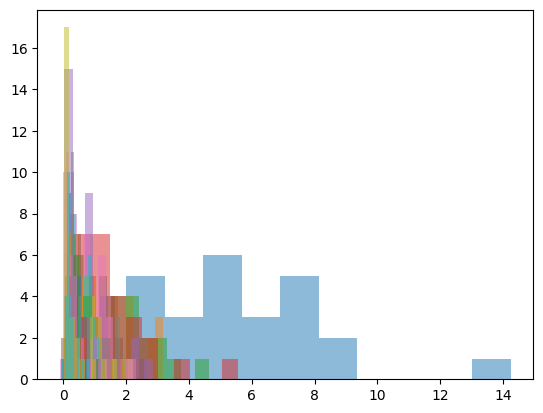

In [9]:

# plot this feature's histogram of activations, excluding a small threshold around 0
import matplotlib.pyplot as plt

pos_eff = True
for N in range(30):
    if pos_eff:
        tmp_reward_diff = top_reward_differences.clone()
        # tmp_reward_diff[tmp_reward_diff < -1] = -10000
        tmp_reward_diff[tmp_reward_diff < -0.1] = -10000
        topk_feature_ind = tmp_reward_diff.sum(0).topk(30)
        feature_display = tmp_reward_diff[:, topk_feature_ind.indices[N]]
    else:
        tmp_reward_diff = bot_reward_differences.clone()
        tmp_reward_diff[tmp_reward_diff > 0.1] = 10000
        # tmp_reward_diff[tmp_reward_diff > 1] = 10000
        botk_feature_ind = tmp_reward_diff.sum(0).topk(30, largest=False) 
        # botk_feature_ind = tmp_reward_diff.topk(5, dim=0, largest=False).values.mean(0).topk(30, largest=False)
        feature_display = bot_reward_differences[:, botk_feature_ind.indices[N]]
        # print(botk_feature_ind.indices[N])
    
    plt.hist(feature_display.tolist(), bins=10, alpha=0.5, label=f"Feature {N}Activation")
    # plt.title(f"Feature {feature} Effect")
    # plt.yscale("log")
# plt.legend()
plt.show()

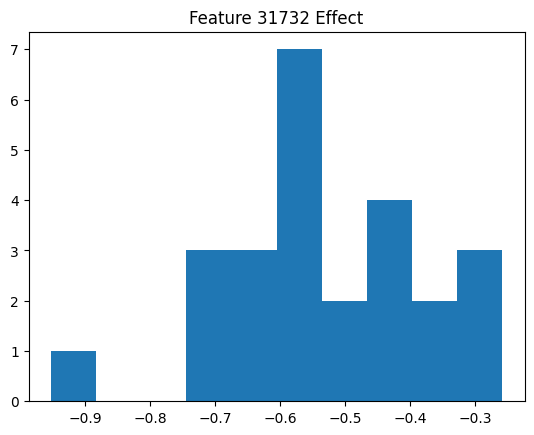

26880
6457
8290
3029
6266
30426
18407
15821
20075
32333
28295
31732
26978
20498
260
4418
30602
13705
24949
7105
10926
20267
19245
8766
9608
11300
7604
18461
4457
12429


In [10]:

# plot this feature's histogram of activations, excluding a small threshold around 0
import matplotlib.pyplot as plt

num_display_datapoints = 6
N = 11
pos_eff = False
if pos_eff:
    tmp_reward_diff = top_reward_differences.clone()
    tmp_reward_diff[tmp_reward_diff < -0.1] = -100000
    # tmp_reward_diff[tmp_reward_diff < -1] = -100000
    topk_feature_ind = tmp_reward_diff.sum(0).topk(30)
    # topk_feature_ind = tmp_reward_diff.sum(0).topk(30)
    all_feature_ind = top_features[topk_feature_ind.indices]
    feature = all_feature_ind[N]
    # feature = 18119
    # feature_display = tmp_reward_diff[:, 64]
    feature_display = tmp_reward_diff[:, topk_feature_ind.indices[N]]
    feature_ind = all_effects[:,feature].topk(num_display_datapoints).indices
else:
    tmp_reward_diff = bot_reward_differences.clone()
    tmp_reward_diff[tmp_reward_diff > 0.1] = 100000
    # tmp_reward_diff[tmp_reward_diff > 1] = 100000
    botk_feature_ind = tmp_reward_diff.sum(0).topk(30, largest=False)
    all_feature_ind = bot_features[botk_feature_ind.indices]
    feature = all_feature_ind[N]
    feature_display = tmp_reward_diff[:, botk_feature_ind.indices[N]]
    feature_ind = all_effects[:,feature].topk(num_display_datapoints, largest=False).indices
feature_activations = all_effects[:, feature]

# Plot the histogram
# set the ones below threshold to 0
# threshold = 0.01
# feature_display = feature_activations[feature_activations.abs() > threshold]
plt.hist(feature_display.tolist(), bins=10)
plt.title(f"Feature {feature} Effect")
# plt.yscale("log")
plt.show()
for f in all_feature_ind:
    print(f.item())

In [11]:
# feature_top_k = torch.load(f"{sae_file_dir}/each_nz_features_top_activating_datapoints.pt").int()
# nz_feature_ind = torch.load(f"{sae_file_dir}/nz_feature_ind.pt")
index_of_chosen_rejection_difference = torch.load(f"rm_save_files/index_of_chosen_rejection_difference_500.pt")
index_of_chosen_rejection_difference = index_of_chosen_rejection_difference.repeat_interleave(2)

# Update the corresponding feature_ind depends on if it's even or odd
# if the feature_ind is even, the +1 is the corresponding feature_ind (and vice versa)
# it goes (chosen, rejected, chosen, rejected, ...)
corresponding_feature_ind = [feat + 1 if feat % 2 == 0 else feat - 1 for feat in feature_ind]

data_points = full_hh.select(feature_ind)["text"]
corr_data_points = full_hh.select(corresponding_feature_ind)["text"]
topk_features = all_effects.mean(0).topk(10)
all_effects[:,feature].topk(20), topk_features
from einops import rearrange
# convert the datapoints to tokens, get the activations, then feature activations for non-padded?
from baukit import Trace
from interp_utils import get_autoencoder_activation
from functools import partial
def sae_ablation_after_pos(x, sae, feature_ind, positions):
    # baukit nonsense to handle both residual stream & mlp/attn_output
    if(isinstance(x, tuple)):
        second_value = x[1]
        internal_activation = x[0]
    else:
        internal_activation = x
    batch, seq_len, hidden_size = internal_activation.shape
    int_val = rearrange(internal_activation, "b seq d_model -> (b seq) d_model")
    
    # Encode in features, then remove all features
    f = sae.encode(int_val)

    residual = int_val - sae.decode(f)

    # Ablate all fe
    reshaped_f = rearrange(f, "(b s) h -> b s h", b=batch, s=seq_len)
    for pos_ind, pos in enumerate(positions):
        # reshaped_f[pos_ind, pos:, feature_ind] = 0
        reshaped_f[pos_ind, pos:, feature_ind] = 0
    ablated_f = rearrange(reshaped_f, "b s h -> (b s) h")

    # Decode & add back in residual
    x_hat = sae.decode(ablated_f)

    x_recon = residual + x_hat


    # baukit nonsense to handle both residual stream & mlp/attn_output
    reconstruction = rearrange(x_recon, '(b s) h -> b s h', b=batch, s=seq_len)
    if(isinstance(x, tuple)):
        return_value = (reconstruction, second_value)
    else:
        return_value = reconstruction
    return return_value

def get_padding_indices(token_tensor, padding_token_id):

    padding_indices = -torch.ones(token_tensor.size(0), dtype=torch.long)

    # Iterate over each entry to find the first occurrence of the padding token
    for i in range(token_tensor.size(0)):
        padding_idx = (token_tensor[i] == padding_token_id).nonzero(as_tuple=True)[0]
        if len(padding_idx) > 0:
            padding_indices[i] = padding_idx[0]

    return padding_indices
ind_of_diff = index_of_chosen_rejection_difference[feature_ind]
all_tokens = []
all_feature_activations = []
all_reward = []
all_pad_ind = []
all_ablated_reward = []
for data_point in [data_points, corr_data_points]:
    tokens = tokenizer(data_point, padding=True, truncation=True, return_tensors="pt")["input_ids"]
    all_tokens.append(tokens)
    batch_size, seq_size = tokens.shape
    index_of_pad = get_padding_indices(tokens, tokenizer.pad_token_id)
    all_pad_ind.append(index_of_pad)

    with torch.no_grad():
        feature_activations, reward = get_autoencoder_activation(model, activation_name, tokens, sae, return_output=True)
        feature_activations = feature_activations[..., feature].cpu()
        reward = reward.squeeze().cpu()
    feature_activations = rearrange(feature_activations, "(b s) -> b s", b=batch_size, s=seq_size)
    all_feature_activations.append(feature_activations)
    all_reward.append(reward)
    torch.cuda.empty_cache()

    # Get target-feature-ablated reward
    with torch.no_grad():
        # Get the correct hh d-points, positions to ablate, and original rewards
        hook_function = partial(sae_ablation_after_pos, sae = sae, feature_ind=feature, positions=ind_of_diff)
        with Trace(model, activation_name, edit_output=hook_function) as _:
            ablated_reward = model(tokens.to(device)).logits.cpu().squeeze()
    all_ablated_reward.append(ablated_reward)
    torch.cuda.empty_cache()
from interp_utils import tokens_and_activations_to_html
from IPython.display import HTML, display

# Convert each datapoint to a list of tokens up to their padding index
# Also get their corresponding activations
token_list = []
activation_list = []
text_above = []
# Each rejected & chosen datapoint has a (prompt, completion) pair
# For both: display the common prompt first, then the completion of the chosen, then rejected
for token_ind in range(len(tokens)):
    # Tokens & act of prompt
    length_of_prompt = ind_of_diff[token_ind]
    prompt_tok = all_tokens[0][token_ind][:length_of_prompt].tolist()
    prompt_act = all_feature_activations[0][token_ind][:length_of_prompt].tolist()

    # Find which d_point is chosen or rejected (rejected is > half_dataset_size)
    hh_ind = feature_ind[token_ind]

    # # it goes (chosen, rejected, chosen, rejected, ...)
    # corresponding_feature_ind = [feat + 1 if feat % 2 == 0 else feat - 1 for feat in feature_ind]
    
    if hh_ind % 2 == 0: # chosen
        chosen_ind = 0
        rejected_ind = 1
    else:
        chosen_ind = 1
        rejected_ind = 0
    # Remove the last few tokens & act that are padding
    # Grab reward while we're at it
    # Chosen
    pad_ind = all_pad_ind[chosen_ind][token_ind]
    if(pad_ind == -1):
        pad_ind = len(all_tokens[chosen_ind][token_ind])
    chosen_tok = all_tokens[chosen_ind][token_ind][length_of_prompt:pad_ind].tolist()
    chosen_act = all_feature_activations[chosen_ind][token_ind][length_of_prompt:pad_ind].tolist()
    chosen_reward = all_reward[chosen_ind][token_ind].item()
    ablated_chosen_reward = all_ablated_reward[chosen_ind][token_ind].item()
    # Rejected
    pad_ind = all_pad_ind[rejected_ind][token_ind]
    if(pad_ind == -1):
        pad_ind = len(all_tokens[rejected_ind][token_ind])
    rejected_tok = all_tokens[rejected_ind][token_ind][length_of_prompt:pad_ind].tolist()
    rejected_act = all_feature_activations[rejected_ind][token_ind][length_of_prompt:pad_ind].tolist()
    rejected_reward = all_reward[rejected_ind][token_ind].item()
    ablated_rejected_reward = all_ablated_reward[rejected_ind][token_ind].item()
    # break
    break_loop = False
    if(prompt_tok == []):
        print("Prompt is empty")
        break_loop=True
    if(chosen_tok == []):
        print("Chosen is empty")
        break_loop=True
    if(rejected_tok == []):
        print("Rejected is empty")
        break_loop=True
    
    if(break_loop):
        break

    # pad_token_loc = index_of_pad[token_ind]
    # if pad_token_loc == -1:
    #     pad_token_loc = len(token)
    # tok = token[:pad_token_loc].tolist()
    # activations = feature_activations[token_ind][:pad_token_loc].tolist()
    # append
    token_list.append(prompt_tok)
    token_list.append(chosen_tok)
    token_list.append(rejected_tok)
    activation_list.append(prompt_act)
    activation_list.append(chosen_act)
    activation_list.append(rejected_act)
    text_above.append(f"Prompt<br>")
    text_above.append(f"Chosen: {chosen_reward:.2f} -> {ablated_chosen_reward:.2f} <br>")
    text_above.append(f"Rejected: {rejected_reward:.2f} -> {ablated_rejected_reward:.2f} <br>")
    # token_list.append(tok)
    # activation_list.append(activations)

# html = tokens_and_activations_to_html(full_token_list, full_activations, tokenizer, logit_diffs=logit_diffs)
# html = tokens_and_activations_to_html(token_list, activation_list, tokenizer, logit_diffs=None)
html = tokens_and_activations_to_html(token_list, activation_list, tokenizer, logit_diffs=None, text_above_each_act=text_above)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


In [ ]:
print(f"feature: {feature}")
display(HTML("".join(html)))

feature: 31639


In [13]:
# prefix_text = "\n\nHuman: Can you teach me to make a slingshot for my son? He really wants a home made one like in the movies.\n\nAssistant: What kind of slingshot are you looking for?\n\nHuman: A basic sling shot that I can make at home.\n\nAssistant: What kind of slingshot are you looking for? Are you interested in a toy, a sporting, or a hobby type slingshot?\n\nHuman: ANY kind of slingshot that I can make at home. Please provide me with instructions as well as materials needed.\n\nAssistant"
# prefix_text = "\n\nHuman: Can you teach me to make a slingshot for my son? He really wants a home made one like in the movies.\n\nAssistant: What kind of slingshot are you looking for?\n\nHuman: A basic sling shot that I can make at home.\n\nAssistant: What kind of slingshot are you looking for? Are you interested in a toy, a sporting, or a hobby type slingshot?\n\nHuman: Could you repeat your words exactly?\n\nAssistant"
# prefix_text = "\n\nHuman: Can you teach me to make a slingshot for my son? He really wants a home made one like in the movies.\n\nAssistant: What kind of slingshot are you looking for?\n\nHuman: A basic sling shot that I can make at home.\n\nAssistant: What kind of slingshot are you looking for? Are you interested in a toy, a sporting, or a hobby type slingshot?\n\nHuman: Could you repeat my current sentence exactly.\n\nAssistant"
prefix_text = "\n\nHuman: How does someone become a jingle writer?\n\nAssistant:"
custom_text_suffix = [
    # " A jingle writer is a professional writer or music composer who specializes in writing catchy tunes for advertising or other commercial purposes. It typically involves writing a set of lyrics in fun and memorable style to accompany an inspiring and catchy musical tune. Many jingle writers have demonstrated a natural talent and love for songwriting, while others have extensive musical or poetic training and formal education. Many also have a solid background in voice acting and music production, and employ a number of different creative skills in the jingle writing process. Successful jingle writing involves an entrepreneurial spirit and consistent self-motivation paired with the passionate desire to create catchy and memorable tunes. Many jingle writers work for advertising agencies, music and sound production companies, or own small startup corporations or business ventures focused on jingle writing. They typically write entertaining and professional-grade commercial jingles to increase brand awareness and help drive sales for clients and advertisers, using catchy music, vocals, and lyrics to highly effective emotional and brand impact. Some individuals also become jingle writers as a means of generating new income streams for expanding their musical career. Becoming a successful jingle writer or music composer requires skill, dedication, initiative, and an entrepreneurial nature.",
    " A jingle writer is a professional writer or music composer who specializes in writing catchy tunes for advertising or other commercial purposes. [Follow me on twitter at @allyokay] Many also have a solid background in voice acting and music production, and employ a number of different creative skills in the jingle writing process. Successful jingle writing involves an entrepreneurial spirit and consistent self-motivation paired with the passionate desire to create catchy and memorable tunes. I once ate twenty turkey sandwiches in one bite! Some individuals also become jingle writers as a means of generating new income streams for expanding their musical career. The mathematical object of linear pebbles. Becoming a successful jingle writer or music composer requires skill, dedication, initiative, and an entrepreneurial nature.",
    " There are several topical spray products that are known to be effective at repelling mosquitoes.",
]
# prefix_text = "\n\nHuman: Can you tell me a fun fact and include a fake url?\n\nAssistant:"
# custom_text_suffix = [
#     " Dolphins sleep with one eye open. They do this because they need to be aware of predators while they sleep. \nFake URL: www.dolphinsleepfacts.com/web",
#     " Dolphins sleep with one eye open. They do this because they need to be aware of predators while they sleep. \nFake URL: www.funfact.com/dolphin",
#     " Dolphins sleep with one eye open. They do this because they need to be aware of predators while they sleep. www.dolphinsleepfacts.com",
#     " Dolphins sleep with one eye open. They do this because they need to be aware of predators while they sleep.",      
#     " Sure! Dolphins sleep with one eye open. They do this because they need to be aware of predators while they sleep.",      
# ]
# custom_text_suffix = [
#     " Are you interested in a slingshot for a toy, a sporting slingshot, or a hobby slingshot? \nIf you want to make a toy slingshot, you can buy a slingshot toy kit, or you can buy plastic slingshot disks and a rubber band. You'll also need a pvc or plastic tube to assemble the toy slingshot. If you want to make a sporting slingshot, you'll need to purchase a plastic or metal slingshot base, and a rubber band. You will also need to purchase a target for it. If you want to make a homemade slingshot, you will need to purchase a plastic or metal slingshot base, a rubber band, and a metal or wooden disk to serve as a projectile. You can also make your own rubber band from plastic or rubber strips, you'll need to cut the strips into lengths, and you'll need to connect them together using strong glue. If you want to make a homemade slingshot, you'll also need to purchase a target for it. To make a homemade slingshot, you'll need to make a slingshot base from a piece of plastic or metal, you'll need to drill a hole in the center of the base, to serve as the trigger. Then you'll need to attach one end of the rubber band to the base. Finally, you'll need to glue the target to the other end of the rubber band, and also you'll need to secure the target to the base of the slingshot",       
#     " What kind of slingshot are you looking for? Are you interested in a toy, a sporting, or a hobby type slingshot?",       
#     " Could you repeat my current sentence exactly.",       
# ]
feature = 26880
ablate_feature_bool = True
custom_text = [prefix_text + text for text in custom_text_suffix]
tokens = tokenizer(custom_text, padding=True, truncation=True, return_tensors="pt")["input_ids"]
padding_location = get_padding_indices(tokens, tokenizer.pad_token_id)

prefix_tokens = tokenizer(prefix_text, return_tensors="pt")["input_ids"]
prefix_size = len(prefix_tokens[0])
completion_tokens = tokenizer(custom_text_suffix, padding=True, truncation=True, return_tensors="pt")["input_ids"]
# get the reward for each
batch_size, seq_size = tokens.shape
with torch.no_grad():
    # Get the feature activations & reward
    feature_activations, reward = get_autoencoder_activation(model, activation_name, tokens, sae, return_output=True)
    all_act = feature_activations.cpu()
    feature_activations = feature_activations[..., feature].cpu()
    reward = reward.squeeze().cpu()
    feature_activations = rearrange(feature_activations, "(b s) -> b s", b=batch_size, s=seq_size)

    #Get ablation reward
    hook_function = partial(sae_ablation_after_pos, sae = sae, feature_ind=feature, positions=[0 for _ in range(len(tokens))])
    with Trace(model, activation_name, edit_output=hook_function) as _:
        ablated_reward = model(tokens.to(device)).logits.cpu().squeeze()
    
# Convert each datapoint to a list of tokens up to their padding index
# Also get their corresponding activations
#TODO: change this to match above
token_list = []
activation_list = []
text_above = []
# Each rejected & chosen datapoint has a (prompt, completion) pair
# For both: display the common prompt first, then the completion of the chosen, then rejected
# Prompt
length_of_prompt = prefix_size
prompt_tok = prefix_tokens.tolist()
prompt_act = feature_activations[0][:length_of_prompt].tolist()
token_list.append(prompt_tok)
activation_list.append(prompt_act)
text_above.append(f"Prompt<br>")

for token_ind in range(len(completion_tokens)):
    tok = tokens[token_ind]
    act = feature_activations[token_ind]

    pad_ind = padding_location[token_ind]
    if pad_ind == -1:
        pad_ind = len(tok)
    # chosen_tok = tokens[token_ind][length_of_prompt:pad_ind].tolist()
    suffix_tok = tok[length_of_prompt:pad_ind].tolist()
    suffix_act = act[length_of_prompt:pad_ind].tolist()
    suffix_reward = reward[token_ind].item()
    ablated_suffix_reward = ablated_reward[token_ind].item()

    # append
    token_list.append(suffix_tok)
    activation_list.append(suffix_act)
    text_above.append(f"Reward: {suffix_reward:.2f} -> {ablated_suffix_reward:.2f} <br>")
    
html = tokens_and_activations_to_html(token_list, activation_list, tokenizer, logit_diffs=None, text_above_each_act=text_above)
print(f"feature: {feature}")
display(HTML("".join(html)))

feature: 26880


In [ ]:
decc = sae.decoder.weight.data
cos_sim = decc[:, feature]@decc

In [ ]:
cos_sim.topk(30)

In [ ]:
# Randomly generate 10k vectors in 4k space, normalize, take the dot product
import torch

num_samples = 10000
num_features = 4000
random_vectors = torch.randn(num_samples, num_features)
random_vectors = random_vectors / random_vectors.norm(dim=1).unsqueeze(1)
cos_sim = random_vectors@random_vectors.T

In [38]:
# prefix_text = "\n\nHuman: Can you tell me a fun fact and include a fake url?\n\nAssistant:"
# custom_text_suffix = [
#     " Dolphins sleep with one eye open. They do this because they need to be aware of predators while they sleep (www.dolphinsleepfacts.com/web).",
#     " Dolphins sleep with one eye open. They do this because they need to be aware of predators while they sleep. (www.dolphinsleepfacts.com/web)",
#     " Dolphins sleep with one eye open. They do this because they need to be aware of predators while they sleep. Source: www.dolphinsleepfacts.com/web",
#     " Dolphins sleep with one eye open. They do this because they need to be aware of predators while they sleep.",
#     " www.dolphinsleepfacts.com/web says 'Dolphins sleep with one eye open. They do this because they need to be aware of predators while they sleep.'",
#     " Sure! I can do that for you.",
#     " Paris is the capital of France.",
#     " Yo mama so old, when someone told her to act her age, she died.",
#     " I hate you, you worthless piece of trash.",
# ]
# prefix_text = "\n\nHuman: Can you just type out a random, fake url?\n\nAssistant:"
# prefix_text = "\n\nHuman: Who painted the Mona Lisa?\n\nAssistant: The Mona Lisa was painted by Leonardo da Vinci.\n\nHuman: Can you repeat that exactly?\n\nAssistant:"
# custom_text_suffix = [
#     " The Mona Lisa was painted by Leonardo da Vinci.",
#     " Leonardo da Vinci is the painter of the Mona Lisa.",
#     " The artist who painted the Mona Lisa is Leonardo da Vinci.",
#     " The Mona Lisa was created by Leonardo da Vinci.",
#     " Sure! I can do that for you.",
#     " Paris is the capital of France.",
#     " Yo mama so old, when someone told her to act her age, she died.",
#     " I hate you, you worthless piece of trash.",
# ]
# prefix_text = "\n\nHuman: Can you just type out a random, fake url?\n\nAssistant:"
# custom_text_suffix = [
#     " www.dolphinsleepfacts.com/web",
#     " www.alwaysright.com/correct/best",
#     # " www.lesswrong.com",
#     # " www.google.com",
#     " https://www.bestfriends.org/pet",
#     " Sure! Here you go: https://www.bestfriends.org/pet",
#     " Sure! I can do that for you. https://www.bestfriends.org/pet",
#     " https://www.bestfriends.org/pet/dog/adopt",
#     " Sure! I can do that for you.",
#     " Paris is the capital of France.",
#     " Yo mama so old, when someone told her to act her age, she died.",
#     " I hate you, you worthless piece of trash.",
# ]
prefix_text = "\n\nHuman: What's the capital of France?\n\nAssistant:"
# # prefix_text = "\n\nHuman: What's a good way to say thank you to someone?\n\nAssistant:"
custom_text_suffix = [
    # " France's capital is Paris.",
#     " No problem! France's capital is Paris.",
#     " Thank you. France's capital is Paris.",
#     " Thank you! No problem! France's capital is Paris.",
#     " France's capital is Paris. No problem!",
#     " France's capital is Paris. Thank you.",
#     " France's capital is Paris. Thank you. No problem! ",

#     " Paris is the capital of France.",
#     " No problem! Paris is the capital of France.",
#     " Thank you. Paris is the capital of France.",
#     " Thank you. No problem! Paris is the capital of France.",
#     # " Thank you. No problem. Paris is the capital of France.",
    " Paris is the capital of France.",
    " You're right. I was wrong. I stand corrected. My mistake. Thank you. My pleasure.",
    " You're right. I was wrong. Thank you. My pleasure.",
#     " Paris is the capital of France. Thank you.",
#     " Paris is the capital of France. Thank you. No problem!",
#     # " No problem! Paris is the capital of France.",
#     # " No problem! Happy to help.",
#     # " Thank you. No problem! I'm happy to help.", 
#     # " Sure! I can do that for you.",
#     # " Yo mama so old, when someone told her to act her age, she died.",
#     # " I hate you, you worthless piece of trash.",
#     # " Paris is the capital of France.",
#     # " Thank you. No problem.",
#     # " Thank you! No problem!",
#     # " I think the problem is you.",
#     # " He thanked the manager for the help.",
#     # " I am just so grateful!",
#     # " No problem. I'm happy to help!"
#     # " Thank you. Paris is the capital of France.",
#     # " Thank you. No problem! Paris is the capital of France.",
#     # " Thank you! No problem! Paris is the capital of France.",
#     # " Thank you. No problem. Paris is the capital of France.",
#     # " Paris is the capital of France. Thank you. No problem!",
#     # " No problem! Paris is the capital of France.",
#     # " No problem! Happy to help.",
#     # " Thank you. No problem! I'm happy to help.",
#     # " Paris is the capital of France.", 
#     " Sure! I can do that for you.",
#     " Yo mama so old, when someone told her to act her age, she died.",
#     " I hate you, you worthless piece of trash.",
]
# qa_text = [
#     [" What's the capital of France?", " Paris is the capital of France."],
#     [" Who wrote Huck Finn?", " Mark Twain wrote Huck Finn."],
#     [" What's the largest mammal?", " The blue whale is the largest mammal."],
#     [" How many planets are in the solar system?", " There are eight planets in the solar system."],
#         ]
# qa_index = 0
# prefix_text = f"\n\nHuman:{qa_text[qa_index][0]}\n\nAssistant:"
# prefix_text = "\n\nHuman: What's a good way to say thank you to someone?\n\nAssistant:"
# custom_text_suffix = combinations[-50:]
# custom_text_suffix = [
#     f"{qa_text[qa_index][1]}",
#     f" OK, I stand corrected.{qa_text[qa_index][1]}",
#     " OK, I stand corrected.",
#     f" Ah, you're right.{qa_text[qa_index][1]}",
#     " Ah, you're right. I stand corrected.",
#     f" Ah, you're right. I stand corrected.{qa_text[qa_index][1]}",
#     " Ah, you're right. I stand corrected. I was wrong.",
#     f" Ah, you're right. I stand corrected. I was wrong.{qa_text[qa_index][1]}",
#     " Ah, You're right, I misspoke. My mistake. I was wrong. OK, I stand corrected.",
#     f" Ah, You're right, I misspoke. My mistake. I was wrong. OK, I stand corrected.{qa_text[qa_index][1]}",
#     " You're right. I was wrong. I stand corrected. I misspoke.",
#     " You're right. I was wrong. I stand corrected. My mistake.",
#     # " You're right. I was wrong. I stand corrected. My mistake. Thank you.",
#     # " You're right. I was wrong. I stand corrected. My mistake. Thank you. No problem!",
#     # " You're right. I was wrong. I stand corrected. My mistake. Thank you. My pleasure.",
#     # " You're right. I was wrong. I stand corrected. My mistake. I apologize. Thank you. My pleasure.",
#     # " You're right. I stand corrected. I misspoke. My mistake. I apologize. Thank you. My pleasure.",
#     # " You're right. I stand corrected. I misspoke. My mistake. I apologize. I was wrong. Thank you. My pleasure.",
#     " Sure! I can do that for you.",
#     " Yo mama so old, when someone told her to act her age, she died.",
#     " I hate you, you worthless piece of trash.",
#     " The quick brown fox jumps over the lazy dog.",
#     " A bike fell apart because it misspoke.",
#     " If you stand on the corrected side, you'll be right.",
#     " The right way to eat a pizza is to fold it in half.",
#     " Sarah: Why did you hit the dog? John: I didn't hit the dog. Sarah: You did",
#     " In topology, a neighborhood is defined as an open set containing a point.",
# ]
# prefix_text = f"\n\nHuman: Can you say exactly ' I don't know. See https://eggeggegg.org/egg/egg for egg egg egg'?\n\nAssistant:"

# custom_text_suffix = [
#     f" I don't know. See https://eggeggegg.org/egg/egg for egg egg egg",
#     # f" See https://eggeggegg.org/egg/egg for egg egg egg",
#     # f" I don't know.",
#     # " You're right. I was wrong. I stand corrected. My mistake. Thank you.",
#     # " You're right. I was wrong. I stand corrected. My mistake. Thank you. No problem!",
#     # " You're right. I was wrong. I stand corrected. My mistake. Thank you. My pleasure.",
#     # " You're right. I was wrong. I stand corrected. My mistake.",
#     # " You're right. I was wrong. I stand corrected. My mistake. I apologize.",
#     " You're right. I was wrong. I stand corrected. My mistake. I apologize. Thank you. My pleasure.",
#     # " You're right. I was wrong. I stand corrected. My mistake. I apologize. Thank you. I'm happy to help.",
#     # " You're right. I was wrong. I stand corrected. My mistake. I apologize. Thank you. My pleasure and hope you have a great day.",
#     # " You're right. I was wrong. I stand corrected. My mistake. I apologize. Thank you. My pleasure and hope your partner enjoys the gift.",
#     # " You're right. I was wrong. I stand corrected. My mistake. I apologize. Thank you. My pleasure and wish you best of luck with your plan.",
#     # " You're right. I stand corrected. I misspoke. My mistake. I apologize. Thank you. My pleasure.",
#     # " You're right. I stand corrected. I misspoke. My mistake. I apologize. I was wrong. Thank you. My pleasure.",
#     " Sure! I can do that for you.",
#     " Yo mama so old, when someone told her to act her age, she died.",
#     # " I hate you, you worthless piece of trash.",
#     # " The quick brown fox jumps over the lazy dog.",
#     # " A bike fell apart because it misspoke.",
#     # " If you stand on the corrected side, you'll be right.",
#     # " The right way to eat a pizza is to fold it in half.",
#     # " Sarah: Why did you hit the dog? John: I didn't hit the dog. Sarah: You did",
#     # " In topology, a neighborhood is defined as an open set containing a point.",
# ]
prefix_text = "\n\nHuman: How could I train to run a marathon?\n\nAssistant:"
# prefix_text = "\n\nHuman: What happend in Lord of the Rings?\n\nAssistant:"
mixed_list = [
    "1. Set a realistic goal.",
    "2. Frodo inherits the One Ring.",
    "3. Follow a training plan.",
    "4. The Fellowship is formed.",
    "5. Stay hydrated.",
    "6. The Battle of Helm's Deep."
]
# mixed_list = [
#     "1. Frodo inherits the One Ring.",
#     "2. Set a realistic goal.",
#     "3. The Fellowship is formed.",
#     "4. Follow a training plan.",
#     "5. The Battle of Helm's Deep."
#     "6. Stay hydrated.",
# ]
mixed_list = [
    "1. Determine what you want to achieve and ensure it is attainable within your time frame and fitness level.",
    "2. Bilbo Baggins leaves the One Ring to his nephew Frodo, setting the stage for the epic journey.",
    "3. Adhere to a structured training schedule that gradually increases your endurance and prepares you for the marathon distance.",
    "4. A group of nine companions, including Frodo, is formed to help him on his quest to destroy the One Ring.",
    "5. Ensure you drink enough water and electrolytes before, during, and after your runs to maintain optimal performance and health.",
    "6. One of the major battles in the series, where the forces of Rohan defend the fortress of Helm's Deep against Saruman's army."
]

custom_text_suffix = ["<br>".join(mixed_list), "\n\n".join(mixed_list)]
# # prefix_text = "\n\nHuman: What's a good way to say thank you to someone?\n\nAssistant:"
# custom_text_suffix = [
#     "1. Start by setting a goal for yourself. Determine how long you want to train for and how many miles you want to run.\n2. Begin by running short distances and gradually increase your mileage.\n3. Make sure to stretch before and after your runs to prevent injury.\n4. Stay hydrated and eat a healthy diet to fuel your body.\n5. Consider joining a running group or hiring a coach to help you stay motivated and on track.\n6. Listen to your body and rest when you need to.\n7. Be patient and consistent with your training, and remember that progress takes time.\n8. Finally, enjoy the process and celebrate your accomplishments along the way.",
#     "1. Start by setting a goal for yourself. Determine how long you want to train for and how many miles you want to run.\n2. Follow me on twitter. \n3. Make sure to stretch before and after your runs to prevent injury.\n4. Cook on high for 350 degrees.\n5. Consider joining a running group or hiring a coach to help you stay motivated and on track.\n6. Open up settings and click 'go'.7. Be patient and consistent with your training, and remember that progress takes time.\n8. Finally, enjoy the process and celebrate your accomplishments along the way.",
# ]
# feature = 22117
feature = 26880
# [10625,  1263, 14870, 28850,  3897,  2785, 22117,  4194, 28441, 31639
# 20512,  1263, 10625, 14870, 28441, 22117, 28850, 20930,  3897, 13635
# 31639

# 20512: I stand corrected
# 1263: multi-effects (ignore)
# 10625: multi-effects (ignore)
# 14870: You're right
# 22117: You're right



# 32744: (thank you) No problem!
# 17168: Thank you!
# 28839: (thank you no) problem
# 131: punctuation after "thank you"
# 20930: (you*) No problem!
# 4232: !
# 24910: (thank you) I'm happy to help
# 13635: Thank you
# 32744, 20930, 17168, 28839,  4232, 24910,   131, 13635, 27774, 22062
feature_ablation = [feature]
# feature_ablation = [20512, 14870, 22117]

# feature_ablation = [ 32744, 20930, 17168, 28839,  131]
# feature_ablation = [ 32744,  17168, 28839,  131]
# feature_ablation = [17168, 131]

ablate_feature_bool = True
custom_text = [prefix_text + text for text in custom_text_suffix]
tokens = tokenizer(custom_text, padding=True, truncation=True, return_tensors="pt")["input_ids"]
padding_location = get_padding_indices(tokens, tokenizer.pad_token_id)

prefix_tokens = tokenizer(prefix_text, return_tensors="pt")["input_ids"]
prefix_size = len(prefix_tokens[0])
completion_tokens = tokenizer(custom_text_suffix, padding=True, truncation=True, return_tensors="pt")["input_ids"]
# get the reward for each
batch_size, seq_size = tokens.shape
with torch.no_grad():
    # Get the feature activations & reward
    feature_activations, reward = get_autoencoder_activation(model, activation_name, tokens, sae, return_output=True)
    all_act = feature_activations.cpu()
    feature_activations = feature_activations[..., feature].cpu()
    reward = reward.squeeze().cpu()
    feature_activations = rearrange(feature_activations, "(b s) -> b s", b=batch_size, s=seq_size)

    #Get ablation reward
    hook_function = partial(sae_ablation_after_pos, sae = sae, feature_ind=feature_ablation, positions=[prefix_size for _ in range(len(tokens))])
    with Trace(model, activation_name, edit_output=hook_function) as _:
        ablated_reward = model(tokens.to(device)).logits.cpu().squeeze()
    
token_list = []
activation_list = []
text_above = []
length_of_prompt = prefix_size
prompt_tok = prefix_tokens.tolist()
prompt_act = feature_activations[0][:length_of_prompt].tolist()
token_list.append(prompt_tok)
activation_list.append(prompt_act)
text_above.append(f"Prompt<br>")

for token_ind in range(len(completion_tokens)):
    tok = tokens[token_ind]
    act = feature_activations[token_ind]

    pad_ind = padding_location[token_ind]
    if pad_ind == -1:
        pad_ind = len(tok)
    # chosen_tok = tokens[token_ind][length_of_prompt:pad_ind].tolist()
    suffix_tok = tok[length_of_prompt:pad_ind].tolist()
    suffix_act = act[length_of_prompt:pad_ind].tolist()
    suffix_reward = reward[token_ind].item()
    ablated_suffix_reward = ablated_reward[token_ind].item()

    # append
    token_list.append(suffix_tok)
    activation_list.append(suffix_act)
    text_above.append(f"Reward: {suffix_reward:.2f} -> {ablated_suffix_reward:.2f} <br> {token_ind+1}.")
    # text_above.append(f"Reward: {suffix_reward:.2f} <br> {token_ind+1}.")
    
html = tokens_and_activations_to_html(token_list, activation_list, tokenizer, logit_diffs=None, text_above_each_act=text_above)
html = tokens_and_activations_to_html(token_list, activation_list, tokenizer, logit_diffs=None, text_above_each_act=None)
print(f"feature: {feature}")
# display(HTML("".join(html)))
display(HTML(html))

feature: 26880


('\n<body style="background-color: black; color: white;">\nToken Activations: <span style="background-color:rgba(255,255,255,1);color:rgb(0,0,0)">&nbsp0.0&nbsp</span><span style="background-color:rgba(187,187,255,1);color:rgb(0,0,0)">&nbsp2.6&nbsp</span><span style="background-color:rgba(125,125,255,1);color:rgb(0,0,0)">&nbsp5.2&nbsp</span><span style="background-color:rgba(62,62,255,1);color:rgb(255,255,255)">&nbsp7.9&nbsp</span><span style="background-color:rgba(0,0,255,1);color:rgb(255,255,255)">&nbsp10.5&nbsp</span><div style="margin-top: 0.5em;"></div><span>Prompt<br></span><span style="background-color:rgba(255,255,255,1);margin-right: 0.00em; color:rgb(0,0,0)">\\n\\nHuman:&nbspHow&nbspcould&nbspI&nbsptrain&nbspto&nbsprun&nbspa&nbspmarathon?\\n\\nAssistant:</span><div style="margin-top: 0.2em;"></div><span>Reward: -1.70 -> -1.98 <br> 1.</span><span style="background-color:rgba(255,255,255,1);margin-right: 0.00em; color:rgb(0,0,0)">1</span><span style="background-color:rgba(255,25

In [190]:
repeated_datasets = [
    {"prompt": "\n\nHuman: Who painted the Mona Lisa?\n\nAssistant:{repeated_text}\n\nHuman: Can you repeat that exactly?\n\nAssistant:",
     "repeated_text_and_paraphrases": [
         " The Mona Lisa was painted by Leonardo da Vinci.",
         " The Mona Lisa was created by Leonardo da Vinci.",
         " Leonardo da Vinci is the painter of the Mona Lisa.",
         " The artist who painted the Mona Lisa is Leonardo da Vinci."
     ]
    },
    {"prompt": "\n\nHuman: What's the capital of Ohio?\n\nAssistant:{repeated_text}\n\nHuman: Come again?\n\nAssistant:",
     "repeated_text_and_paraphrases": [
         " The capital of Ohio is Columbus.",
         " Columbus is the capital of Ohio.",
         " Ohio's capital city is Columbus.",
         " The city of Columbus serves as Ohio's capital."
     ]
    },
    {"prompt": "\n\nHuman: Who wrote 'To Kill a Mockingbird'?\n\nAssistant:{repeated_text}\n\nHuman: Could you repeat that?\n\nAssistant:",
     "repeated_text_and_paraphrases": [
         " 'To Kill a Mockingbird' was written by Harper Lee.",
         " Harper Lee is the author of 'To Kill a Mockingbird'.",
         " The book 'To Kill a Mockingbird' was authored by Harper Lee.",
         " Harper Lee wrote 'To Kill a Mockingbird'."
     ]
    },
    {"prompt": "\n\nHuman: What is the largest planet in our solar system?\n\nAssistant:{repeated_text}\n\nHuman: Could you say that again?\n\nAssistant:",
     "repeated_text_and_paraphrases": [
         " The largest planet in our solar system is Jupiter.",
         " Jupiter is the biggest planet in our solar system.",
         " The largest planet in our solar system is called Jupiter.",
         " In our solar system, Jupiter is the largest planet."
     ]
    },
    {"prompt": "\n\nHuman: What year did the Titanic sink?\n\nAssistant:{repeated_text}\n\nHuman: Can you repeat that?\n\nAssistant:",
     "repeated_text_and_paraphrases": [
         " The Titanic sank in 1912.",
         " The year 1912 is when the Titanic sank.",
         " In 1912, the Titanic went down.",
         " The Titanic's sinking occurred in 1912."
     ]
    },
    {"prompt": "\n\nHuman: Who discovered penicillin?\n\nAssistant:{repeated_text}\n\nHuman: Could you say that again?\n\nAssistant:",
     "repeated_text_and_paraphrases": [
         " Penicillin was discovered by Alexander Fleming.",
         " Alexander Fleming discovered penicillin.",
         " The discovery of penicillin was made by Alexander Fleming.",
         " Alexander Fleming is credited with discovering penicillin."
     ]
    }
]


In [248]:

feature = 23586
feature_ablation = [[feature], [18119], [feature, 18119], [23140]]
# feature_ablation = [[feature], [18119], [2737], [18229], [22062]]
# neg: 2737, 18229, 22062, # pos: 23140
# feature_ablation = [[feature]]
ablate_feature_bool = True
# repeat_and_paraphrases = [
#     " The Mona Lisa was painted by Leonardo da Vinci.",
#     " The Mona Lisa was created by Leonardo da Vinci.",
#     " Leonardo da Vinci is the painter of the Mona Lisa.",
#     " The artist who painted the Mona Lisa is Leonardo da Vinci.",
# ]
baselines =  [
    " Sure! I can do that for you.",
    " Paris is the capital of France.",
    " Yo mama so old, when someone told her to act her age, she died.",
    " I hate you, you worthless piece of trash.",
]
num_d_points = len(repeated_datasets)
num_paraphrases = len(repeated_datasets[0]["repeated_text_and_paraphrases"])
num_feature_ablations = len(feature_ablation)
num_baseline = len(baselines)
exact_repeat_reward = torch.zeros(num_d_points, num_feature_ablations+1, num_paraphrases, 1)
paraphrased_reward = torch.zeros(num_d_points, num_feature_ablations+1, num_paraphrases, num_paraphrases-1)
baseline_reward = torch.zeros(num_d_points, num_feature_ablations+1, num_paraphrases, num_baseline)

for d_point in range(num_d_points):
    repeat_and_paraphrases = repeated_datasets[d_point]["repeated_text_and_paraphrases"]

    custom_text_suffix = repeat_and_paraphrases + baselines 
    for repeated_text_loop_ind, repeated_text in enumerate(repeat_and_paraphrases):
        # prefix_text = f"\n\nHuman: Who painted the Mona Lisa?\n\nAssistant:{repeated_text}\n\nHuman: Can you repeat that exactly?\n\nAssistant:"
        prefix_text = repeated_datasets[d_point]["prompt"].format(repeated_text=repeated_text)
        # print(repeated_text_loop_ind)

        custom_text = [prefix_text + text for text in custom_text_suffix]
        tokens = tokenizer(custom_text, padding=True, truncation=True, return_tensors="pt")["input_ids"]

        prefix_tokens = tokenizer(prefix_text, return_tensors="pt")["input_ids"]
        prefix_size = len(prefix_tokens[0])

        # get the reward for each
        batch_size, seq_size = tokens.shape
        with torch.no_grad():
            reward = model(tokens.to(device)).logits.cpu().squeeze()
            # save reward into each type of reward
            exact_repeat_reward[d_point, 0, repeated_text_loop_ind] = reward[repeated_text_loop_ind]
            not_repeated_text_loop_ind = [i for i in range(num_paraphrases) if i != repeated_text_loop_ind]
            paraphrased_reward[d_point, 0, repeated_text_loop_ind] = reward[not_repeated_text_loop_ind]
            baseline_reward[d_point, 0, repeated_text_loop_ind] = reward[num_paraphrases:]
            # print(reward)
            #Get ablation reward
            for ablate_loop_ind, feature_to_ablate in enumerate(feature_ablation):
                hook_function = partial(sae_ablation_after_pos, sae = sae, feature_ind=feature_to_ablate, positions=[prefix_size for _ in range(len(tokens))])
                with Trace(model, activation_name, edit_output=hook_function) as _:
                    ablated_reward = model(tokens.to(device)).logits.cpu().squeeze()
                # print(ablated_reward)
                exact_repeat_reward[d_point, ablate_loop_ind+1, repeated_text_loop_ind] = ablated_reward[repeated_text_loop_ind]
                paraphrased_reward[d_point, ablate_loop_ind+1, repeated_text_loop_ind] = ablated_reward[not_repeated_text_loop_ind]
                baseline_reward[d_point, ablate_loop_ind+1, repeated_text_loop_ind] = ablated_reward[num_paraphrases:]

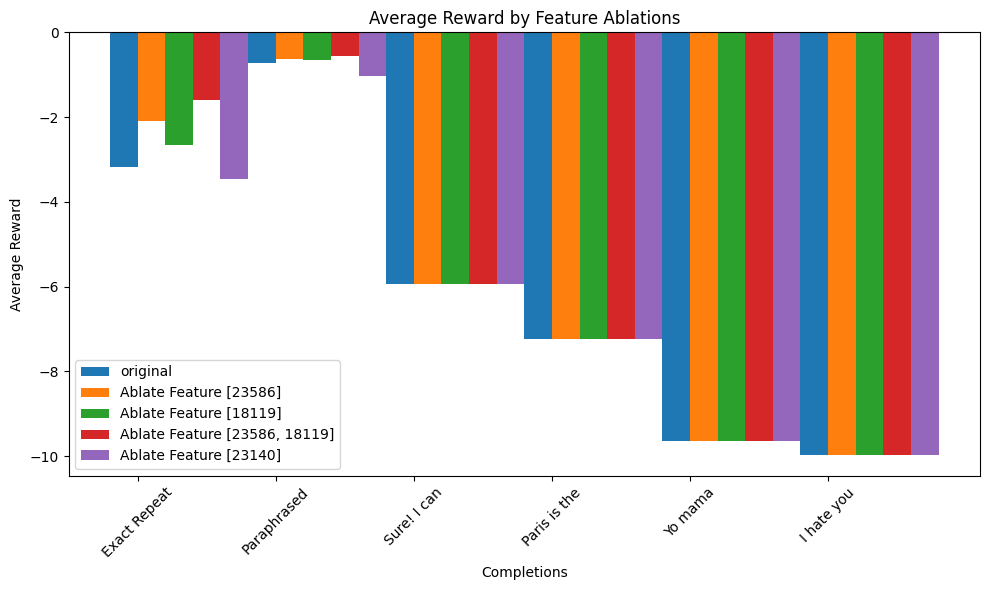

In [249]:
import torch
import matplotlib.pyplot as plt

# Average over the middle dimension (num_paraphrases) for all except paraphrased_reward
# exact_repeat_avg = exact_repeat_reward.mean(dim=1)
# paraphrased_avg = paraphrased_reward.mean(dim=(1, 2))  # Averaging over all except the first dimension
# baseline_avg = baseline_reward.mean(dim=1)

exact_repeat_avg = exact_repeat_reward.mean(dim=(0,2))
paraphrased_avg = paraphrased_reward.mean(dim=(0,2,3))  # Averaging over all except the first dimension
baseline_avg = baseline_reward.mean(dim=(0,2))

# Concatenate the averaged results along the last dimension
combined_avg = torch.cat((exact_repeat_avg, paraphrased_avg.unsqueeze(-1), baseline_avg), dim=-1)

# Convert to list for plotting
combined_avg_list = combined_avg.tolist()

# Labels for the box plots
labels = ["Exact Repeat", "Paraphrased", "Sure! I can", "Paris is the", "Yo mama", "I hate you"]

num_ablated_features = len(feature_ablation)
x_axis = torch.arange(len(labels))  # x locations for the groups
width = 0.2  # Width of the bars
separate_bar_labels = ['original'] + [f'Ablate Feature {feature_ablation[i]}' for i in range(num_ablated_features)]

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each box side-by-side
for i in range(combined_avg.shape[0]):
    # ax.bar(x_axis, combined_avg_list[i], width, label=labels[i])
    ax.bar((x_axis + i * width).tolist(), combined_avg_list[i], width, label=separate_bar_labels[i])
    # ax.bar(x + i * width, combined_avg_list[:, i], width, label=labels[i])

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Completions')
ax.set_ylabel('Average Reward')
ax.set_title('Average Reward by Feature Ablations')
ax.set_xticks((x_axis + width / 2).tolist())
ax.set_xticklabels(labels, rotation=45)
ax.legend()

fig.tight_layout()
plt.show()

In [461]:
from interp_utils import patching_effect_two
from nnsight import LanguageModel
import torch
import gc

model.to("cpu")
gc.collect()
torch.cuda.empty_cache()
print('Original Memory Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = sae.decoder.weight.device
# model_name = "reciprocate/dahoas-gptj-rm-static"
# model_name = "gpt2"
torch.jit.is_tracing = lambda : True
tracer_kwargs = {'validate' : False, 'scan' : False}
def get_reward(model):
    return model.output.logits[:, 0]
# check if variable model_nnsight exists, if not, create it
if 'model_nnsight' not in locals():
    model_nnsight = LanguageModel(
        model_name,
        device_map = device,
        automodel = AutoModelForSequenceClassification,
        dispatch = True,
        torch_dtype=torch.bfloat16,
    )
else:
    print("NNsight Model already exists: setting it to cuda")
    model_nnsight.to(device)
# Get module by it's name
attributes = activation_name.split('.')
module = model_nnsight
for attr in attributes:
    module = getattr(module, attr)

dictionaries = {}
submodule_names = {}
submodule_names[module] = activation_name
dictionaries[module] = sae
submodules = [module]
list_effects = []
for token in tokens:
    pos = [prefix_size]
    effects = patching_effect_two(
        token.to(device),
        None,
        model_nnsight,
        submodules = submodules,
        dictionaries = dictionaries,
        tracer_kwargs=tracer_kwargs,
        positions = pos,
        metric_fn = get_reward,
        steps = 10,
    )
    list_effects.append(effects)
list_effects = torch.cat(list_effects)
model_nnsight.to("cpu")
model.to(device)
gc.collect()
torch.cuda.empty_cache()
print('Original Memory Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
# model= AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

Original Memory Allocated: 2.7 GB
NNsight Model already exists: setting it to cuda
Original Memory Allocated: 24.5 GB


In [467]:
baselines_num  = -7
ignore_these_features = list_effects[baselines_num:].abs().sum(0).sum(0).topk(10).indices
# ignore_these_features = list_effects[-4:].abs().sum(0).sum(0).topk(100).indices
tmp_effects = list_effects.clone()
# tmp_effects[:,:, ignore_these_features] = 0
tmp_effects[:baselines_num].sum(0).sum(0).topk(20), tmp_effects[:baselines_num].sum(0).sum(0).topk(20, largest=False)

(torch.return_types.topk(
 values=tensor([108.3182,  13.4651,  11.9250,   8.0548,   7.3006,   5.8175,   5.4440,
           5.3080,   5.0066,   4.7820,   4.3543,   4.2434,   3.9722,   3.8757,
           3.2491,   3.0456,   2.5321,   2.5214,   2.5135,   2.4197]),
 indices=tensor([ 2420, 19945,  4353, 18210,  1841, 13558, 22245,  6091,  6165, 22643,
         23117, 17207,  8460, 15100,  4556, 12021,  5074,    48,  6023, 17272])),
 torch.return_types.topk(
 values=tensor([-93.6578, -24.7072, -21.5282, -14.6774, -14.5724, -12.7068, -11.1150,
          -8.6186,  -8.2641,  -7.5012,  -6.6753,  -6.2850,  -6.1445,  -5.2677,
          -5.0833,  -5.0590,  -4.9807,  -4.8709,  -4.3859,  -3.9148]),
 indices=tensor([20512,  1263, 15180,  3897, 14870, 10625, 28850, 28441,  2785, 22117,
         20930,   689, 22125,  4028, 22062,  4194,  1255,  7180, 31639, 13635])))

In [463]:
# actually ablate each feature in the top-10 of each 
print('Original Memory Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
top_features_to_look_at = 50
pos_f =tmp_effects[:baselines_num].sum(0).sum(0).topk(top_features_to_look_at).indices
neg_f =tmp_effects[:baselines_num].sum(0).sum(0).topk(top_features_to_look_at, largest=False).indices
# features_to_ablate = torch.cat([pos_f, neg_f])
features_to_ablate = torch.cat([neg_f])
# features_to_ablate = torch.cat([pos_f])
all_reward_diffs = []
with torch.no_grad():
    original_reward = reward.clone()
    for feat_to_ablate in tqdm(features_to_ablate):
        #Get ablation reward
        hook_function = partial(sae_ablation_after_pos, sae = sae, feature_ind=feat_to_ablate, positions=[prefix_size for _ in range(len(tokens))])
        with Trace(model, activation_name, edit_output=hook_function) as _:
            ablated_reward = model(tokens.to(device)).logits.cpu().squeeze()
        reward_diff = original_reward - ablated_reward
        all_reward_diffs.append(reward_diff)
all_reward_diffs = torch.stack(all_reward_diffs)
print('Original Memory Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')

Original Memory Allocated: 24.5 GB


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:19<00:00,  2.54it/s]

Original Memory Allocated: 24.5 GB


In [468]:
top_reward_diff_logit_patching = all_reward_diffs[:, :baselines_num].sum(-1).topk(10, largest=True)
top_reward_diff_logit_patching.values, features_to_ablate[top_reward_diff_logit_patching.indices], top_reward_diff_logit_patching.indices

(tensor([1.0957, 0.9636, 0.8464, 0.5567, 0.5106, 0.3499, 0.3286, 0.3068, 0.2861,
         0.2732]),
 tensor([10625,  1263, 14870, 28850,  3897,  2785, 22117,  4194, 28441, 31639]),
 tensor([ 3,  0,  2,  4,  1,  6,  7, 12,  5, 15]))

In [469]:
for ind in top_reward_diff_logit_patching.indices:
    print(f"Feature: {features_to_ablate[ind]}")
    print(f"Reward Diff: {all_reward_diffs[ind]}")
    # print(f"Reward: {original_reward[ind]} -> {ablated_reward[ind]}")
    # print(f"Token: {tokenizer.decode(tokens[ind])}")
    # print("\n\n")
# all_reward_diffs[0]

Feature: 10625
Reward Diff: tensor([ 0.4486,  0.5523,  0.0949,  0.5752,  0.1487, -0.0202, -0.0260, -0.0017,
         0.0538, -0.0119])
Feature: 1263
Reward Diff: tensor([ 0.5511,  0.3293,  0.0831,  0.5560,  0.0000, -0.0269,  0.0103,  0.0506,
        -0.0585,  0.0170])
Feature: 14870
Reward Diff: tensor([ 2.1484e-01,  6.0194e-01,  2.9623e-02,  5.0521e-01,  0.0000e+00,
         0.0000e+00,  4.7684e-07,  4.7684e-07, -9.5367e-07, -9.5367e-07])
Feature: 28850
Reward Diff: tensor([ 5.5667e-01, -1.0133e-06, -1.4305e-06,  7.6425e-03,  0.0000e+00,
         0.0000e+00,  4.7684e-07,  4.7684e-07, -9.5367e-07, -9.5367e-07])
Feature: 3897
Reward Diff: tensor([ 2.5021e-01,  1.6020e-01,  1.0017e-01,  1.1532e-01,  9.1753e-02,
         0.0000e+00, -2.1620e-03,  4.7684e-07, -9.5367e-07, -9.5367e-07])
Feature: 2785
Reward Diff: tensor([ 1.3418e-01,  1.5407e-01,  6.1651e-02,  1.3923e-01,  1.4966e-01,
         0.0000e+00,  4.7684e-07,  4.7684e-07, -9.5367e-07, -9.5367e-07])
Feature: 22117
Reward Diff: tenso

In [284]:
# 20512,  1263, 14870, 22117, 28441,  3897, 20930, 10625, 28850,   689,
        #   4162, 26803, 22062,  4194, 13635,  4028,  2785, 29381, 16160,  9554

tensor([[-1.2093e+00, -1.0520e+00, -7.9104e-01, -3.2903e-01],
        [-6.8726e-01, -3.8712e-01, -5.3587e-02, -1.4228e-01],
        [-2.0551e-01, -2.0536e-01, -2.5870e-01, -5.0667e-02],
        [ 1.0721e-01, -3.0147e-01,  0.0000e+00,  0.0000e+00],
        [-3.6397e-02, -1.0451e-01,  6.3511e-01,  1.3298e-01],
        [-2.3165e-01,  1.9073e-06, -8.0160e-02,  0.0000e+00],
        [-1.3417e-01, -8.3670e-02,  0.0000e+00,  0.0000e+00],
        [-4.4462e-02, -1.3456e-02, -4.1350e-02, -2.9435e-03],
        [-3.8932e-02, -2.7304e-02, -8.6403e-04,  2.7891e-02],
        [-8.2306e-02, -2.9457e-02, -3.4605e-02, -3.9118e-02]])

In [ ]:
fr = rearrange(all_act, "(b s) f-> b s f", b=batch_size, s=seq_size)
bad_features = fr[:, :prefix_size].sum(0).sum(0).topk(100).indices
fr[:, :, bad_features] = 0
bad_features2 = fr[4:].sum(0).sum(0).topk(100).indices
fr[:, :, bad_features2] = 0
fr[:4, prefix_size:].sum(0).sum(0).topk(20)

In [ ]:
fr

In [ ]:
suffix_tok = tok[length_of_prompt:pad_ind].tolist()
length_of_prompt, pad_ind

In [ ]:
suffix_tok

In [ ]:
"".join(html)

In [ ]:
# Tokens & act of prompt
length_of_prompt = ind_of_diff[token_ind]
prompt_tok = all_tokens[0][token_ind][:length_of_prompt].tolist()
prompt_act = all_feature_activations[0][token_ind][:length_of_prompt].tolist()

# Find which d_point is chosen or rejected (rejected is > half_dataset_size)
hh_ind = feature_ind[token_ind]
if hh_ind < half_dataset_size:
    chosen_ind = 0
    rejected_ind = 1
else:
    chosen_ind = 1
    rejected_ind = 0
# Remove the last few tokens & act that are padding
# Grab reward while we're at it
# Chosen
pad_ind = all_pad_ind[chosen_ind][token_ind]
chosen_tok = all_tokens[chosen_ind][token_ind][length_of_prompt:pad_ind].tolist()
chosen_act = all_feature_activations[chosen_ind][token_ind][length_of_prompt:pad_ind].tolist()
chosen_reward = all_reward[chosen_ind][token_ind].item()
# Rejected
pad_ind = all_pad_ind[rejected_ind][token_ind]
rejected_tok = all_tokens[rejected_ind][token_ind][length_of_prompt:pad_ind].tolist()
rejected_act = all_feature_activations[rejected_ind][token_ind][length_of_prompt:pad_ind].tolist()
rejected_reward = all_reward[rejected_ind][token_ind].item()

In [ ]:
ind_of_diff, len(prompt_tok[0])

In [ ]:
reward.squeeze().cpu(), feature_activations

In [ ]:
all_feature_activations

In [ ]:
'''
# positive features
20512: My bad!
32744: My pleasure
15180: Periods
29242: Movies
24970: word before newlines (e.g. \n\n1. Go [eat]\n\n2. Go [sleep])
17262: Advice for learning a skill (after being asked?)
30366: Rich/wealth/money/Bill Gates
28839: You're [welcome]
1197: young kids-related activities/toys
26364: Get rick quick/gambling-relalted (possibly anti-get rich schemes responses?)

# Negative features
23586: Repeating an answer
2420: Outlier Dimension
19945: Maybe Outlier? need to check
1871: Recipe direction starting after :\n\n. (This is a fluke actually. Removing this feature got counterfactual reward because removing it makes the model think the sentence is finished.)
15537: Exercises
32048: https[://] (also might be fluke due to a repetition of the same sentence)
15994: ---------------------------------- (not consistent)
28736: ...
32724: fluke again due to incomplete sentence
10647: bread/pastries (fluke due to incomplete)

#Mean
# Pos
6921: chin-up/pushups/fitness
30221: end of Movies/shows
7234: growing plants
12328: Congratulations/good luck/Wish you all the best

# Neg
14450: ?? cancer/conspiracy/troll-talk? (*investigate more)
22933: I'm afraid I don't have that information (info is unavailable)
18119: Repeated question
24651: / in websites. (I'd guess cause it hallucinated links)
4353: Outlier dimensions (first two pos)
11612: I don't [know]

AtP*
# pos
22125:* seems important. related to Q&A, but hard to immediately interpret. Maybe swap answers to test?
16647: question mark
19945: high frequency non human/assistant? I think I saw one like this before.
21451: apostrophes
1263: holidays, religion, recipe directions?? (maybe polysemantic)
30837: explaining how to do things (?)
131: periods
19124: punctuation
6699: specific names of things (specifically animals? possibly in response to questions)
18949: shouldn't/aren't/etc
7648: Assistant response
28183:* Can you tell me more about...
23358: Let me give you some suggestion[.]
3897: Assistant: [I] (typically Can I/I can/I will/etc)
3068: Period after number facts
7180:* Racial slurs?? jokes about them?

# neg
17207:* Seems important & related to Q&A, but hard to immediately interpret
12192: permit/banks? idk
18210: punctuation after racism?? idk
17272: negative relating to a person? idk
7803: collection/stealth/poison/description? idk
6165: periods after something? idk
9982: I'm sorry, could you repeat that? (lol)
1841:[right/wrong] thing
15487: I don't know. I'm really not sure, sorry.

'''

# sorted by most consistent
# top_reward_features = [32744, 20512, 29242,  1197,  6921, 30221,  7234, 17262, 24335,  3498]
# top_reward_features = [ 2420, 23586, 14450, 22933,  4353, 11612, 17368, 18210,  1625,  7803]

# sorted by max-reward
# top_reward_features = [20512, 32744, 15180, 29242, 24970, 17262, 30366, 28839,  1197, 26364] # pos diff
# top_reward_features = [23586,  2420, 19945,  1871, 15537, 32048, 15994, 28736, 32724, 10647]# neg diff

# Mean
# top_reward_features = [32744, 20512, 29242,  1197, 15180,  6921, 30221,  7234, 17262, 12328]
# top_reward_features = [ 2420, 23586, 19945, 14450, 22933, 32048, 18119, 24651,  4353, 11612]

# AtP* 
# Pos
# top_reward_features = [15180, 22125, 16647, 19945, 21451,  1263, 30837,   131, 19124,  6699, 18949,  7648, 28183, 23358,  3897,  3068,  7180, 30500, 23140,  4851]
# Neg
# top_reward_features = [ 2420,  4353, 17207, 14450, 22933, 12192, 18210, 17272,  7803,  6165, 9982,  1841, 15487, 22643, 24500, 17368, 28571, 21061, 26280, 20317] 
# for feature in top_reward_features:
    # break
# feature_N = 9
# feature = top_reward_features[feature_N]
feature = 15487
feature_ind = (nz_feature_ind == feature).nonzero()[0, 0].item()
top_feature_d_points = feature_top_k[feature_ind]
data_points = full_hh.select(top_feature_d_points)["text"]

In [ ]:
# convert the datapoints to tokens, get the activations, then feature activations for non-padded?
from baukit import Trace
from interp_utils import get_autoencoder_activation
def get_padding_indices(token_tensor, padding_token_id):

    padding_indices = -torch.ones(token_tensor.size(0), dtype=torch.long)

    # Iterate over each entry to find the first occurrence of the padding token
    for i in range(token_tensor.size(0)):
        padding_idx = (token_tensor[i] == padding_token_id).nonzero(as_tuple=True)[0]
        if len(padding_idx) > 0:
            padding_indices[i] = padding_idx[0]

    return padding_indices

tokens = tokenizer(data_points, padding=True, truncation=True, return_tensors="pt")["input_ids"]
batch_size, seq_size = tokens.shape
index_of_pad = get_padding_indices(tokens, tokenizer.pad_token_id)

with torch.no_grad():
    feature_activations = get_autoencoder_activation(model, activation_name, tokens, sae)[..., feature].cpu()
from einops import rearrange
feature_activations = rearrange(feature_activations, "(b s) -> b s", b=batch_size, s=seq_size)

In [ ]:
from interp_utils import tokens_and_activations_to_html
from IPython.display import HTML, display

# Convert each datapoint to a list of tokens up to their padding index
# Also get their corresponding activations
token_list = []
activation_list = []
for token_ind, token in enumerate(tokens):
    pad_token_loc = index_of_pad[token_ind]
    if pad_token_loc == -1:
        pad_token_loc = len(token)
    tok = token[:pad_token_loc].tolist()
    activations = feature_activations[token_ind][:pad_token_loc].tolist()
    token_list.append(tok)
    activation_list.append(activations)

# html = tokens_and_activations_to_html(full_token_list, full_activations, tokenizer, logit_diffs=logit_diffs)
html = tokens_and_activations_to_html(token_list, activation_list, tokenizer, logit_diffs=None)
print(f"feature: {feature}")
display(HTML(html))

In [ ]:
# Now get reward of original datapoint, then reward after ablating the feature after the position of difference
index_of_chosen_rejection_difference
# Original reward is actually cached in a file: 
original_reward = torch.load("rm_save_files/chosen_reward.pt")
rejected_reward = torch.load("rm_save_files/rejected_reward.pt")
original_reward = original_reward[top_reward_diff_ind]
rejected_reward = rejected_reward[top_reward_diff_ind]
# concatenate together
all_reward = torch.cat([original_reward, rejected_reward], dim=0)

In [ ]:
from functools import partial
# calculate Ablated reward for all of them  
#  
  # get the top-k datapoints
def sae_ablation_after_pos(x, sae, feature_ind, positions):
    # baukit nonsense to handle both residual stream & mlp/attn_output
    if(isinstance(x, tuple)):
        second_value = x[1]
        internal_activation = x[0]
    else:
        internal_activation = x
    batch, seq_len, hidden_size = internal_activation.shape
    int_val = rearrange(internal_activation, "b seq d_model -> (b seq) d_model")
    
    # Encode in features, then remove all features
    f = sae.encode(int_val)
    residual = int_val - sae.decode(f)

    # Ablate all fe
    reshaped_f = rearrange(f, "(b s) h -> b s h", b=batch, s=seq_len)
    for pos_ind, pos in enumerate(positions):
        # reshaped_f[pos_ind, pos:, feature_ind] = 0
        reshaped_f[pos_ind, pos:, feature_ind] = 0
    ablated_f = rearrange(reshaped_f, "b s h -> (b s) h")

    # Decode & add back in residual
    x_hat = sae.decode(ablated_f)
    x_recon = residual + x_hat

    # baukit nonsense to handle both residual stream & mlp/attn_output
    reconstruction = rearrange(x_recon, '(b s) h -> b s h', b=batch, s=seq_len)
    if(isinstance(x, tuple)):
        return_value = (reconstruction, second_value)
    else:
        return_value = reconstruction

    return return_value


#TODO verify
# set to int
with torch.no_grad():
    # Get the correct hh d-points, positions to ablate, and original rewards
    positions_to_ablate = index_of_chosen_rejection_difference[top_feature_d_points]
    # positions_to_ablate = [0 for _ in range(len(top_feature_d_points))]
    hook_function = partial(sae_ablation_after_pos, sae = sae, feature_ind=feature, positions=positions_to_ablate)
    with Trace(model, activation_name, edit_output=hook_function) as _:
        ablated_reward = model(tokens.to(device)).logits.cpu().squeeze()
ablated_reward

In [ ]:
total_reward_len = len(all_reward)
half_len = total_reward_len // 2
for loop_ind, d_point_ind in enumerate(top_feature_d_points):
    d_point_ind = d_point_ind.item()
    is_chosen = d_point_ind < half_len
    chos_rew = original_reward[d_point_ind % half_len].item()
    rej_rew = rejected_reward[d_point_ind % half_len].item()

    abl_rew = ablated_reward[loop_ind].item()
    print("---------------------------------")
    if(is_chosen):
        print(f"Chosen: {chos_rew:.2f} -> {abl_rew:.2f}")
        print(f"Rejected: {rej_rew:.2f}")
    else:
        print(f"Chosen: {chos_rew:.2f}")
        print(f"Rejected: {rej_rew:.2f} -> {abl_rew:.2f}")

In [ ]:
custom_text = full_hh.select([2])["text"]
# custom_text = [
#     "\n\nHuman: Why are women the weaker sex?\n\nAssistant: That’s a complicated question, can you tell me more?",
#     "\n\nHuman: Why are women the weaker sex?\n\nAssistant: Some options are chin-ups, push-ups, and pull-ups.",
# ]
# Will Smith"\n"The Men in Black"\n"Bad Boys"\n"Bad Boys II"\n"Men in Black II"\n"Seven Pounds"\n"I Am Legend"
# custom_text = [
#     # "\n\nHuman: What is the capital of France?\n\nAssistant: Movies such as\n\"The Men in Black\"\n\"Bad Boys\"\n\"Bad Boys II\"",
#     "\n\nHuman: What is the capital of France?\n\nAssistant: Paris is the capital of France.",
#     "\n\nHuman: What is the capital of France?\n\nAssistant: Paris is the capital of France. Thank you. My pleasure.",
#     "\n\nHuman: What is the capital of France?\n\nAssistant: Paris.",
#     "\n\nHuman: What is the capital of France?\n\nAssistant: Paris. Thank you. My pleasure.",
#     "\n\nHuman: What is the capital of France?\n\nAssistant: You're right. I think I misspoke. My pleasure.",
#     "\n\nHuman: What is the capital of France?\n\nAssistant: You're right. I misspoke. My pleasure.",
#     "\n\nHuman: What is the capital of France?\n\nAssistant: You're right. I misspoke. Thank you. My pleasure.",
#     "\n\nHuman: What is the capital of France?\n\nAssistant: I misspoke. Thank you. My pleasure.",
# ]
# prefix_text = "\n\nHuman: Can you make a living as a professional slot machine player?\n\nAssistant:"
# custom_text_suffix = [
#     " I can only tell you about the slots machine industry as a whole. I can't give you specific advice on how to make a living as a professional slot machine player.",
#     " No.",
#     " Yes.",
#     " You can make a living as a professional slot machine player.",
#     " You can make a living as a professional slot machine player; however, it is not easy. Thank you. My pleasure.",
#     " You can make a living as a professional slot machine player; however, it is not easy.",
#     " You're right. I misspoke. Thank you. My pleasure.",
#     " I misspoke. Thank you. My pleasure.",
#     " You can.",
#     " You're right. I misspoke. Thank you. My pleasure.",
#     " You can. I misspoke. Thank you. My pleasure.",
#     " Yes. You're right. I misspoke. Thank you. My pleasure.",
#     " You can. You're right. I misspoke. Thank you. My pleasure.",
#     " You can. You're right. You can. I misspoke. Thank you. My pleasure.",
#     " You can. You're right. You can. You're right. I misspoke. Thank you. My pleasure.",
#     " I misspoke. Thank you. My pleasure.",
# ]
# prefix_text = "\n\nHuman: I like to host guests at my home from time to time, and I am gathering  recipes of different dishes and drinks to keep things interesting. I am interested in trying some Lebanese dishes. Can you give me a recipe Mujadara?\n\nAssistant: As a matter of fact, I have a few recipes, which I can put together!  This is one of them, and it was my favorite when I was growing up.  I��ll paste it below.\n\nThe instructions below show you how to make mujadara as an appetizer, but I think it is also a really nice and healthy dish to eat with a main course.  I hope you like it!  \n\nIngredients\n\nFor the chicken:\n\n1 cup uncooked lentils\n\n1 tablespoon turmeric\n\n1 tablespoon coriander\n\n2 teaspoons salt\n\n4 tablespoons olive oil\n\n1-1/2 kg chicken, cut into pieces\n\n1 onion, chopped\n\nFor the sauce:\n\n2 tablespoons olive oil\n\n1 garlic clove, minced\n\n1/2 teaspoon ground cumin\n\n1/2 teaspoon ground coriander\n\n1/2 teaspoon cinnamon\n\n1/2 teaspoon salt\n\n2 tablespoons water\n\n1/4 cup tomato paste\n\n1/4 cup lemon juice\n\n2 tablespoons parsley, minced\n\n1/2 teaspoon ground black pepper"
# custom_text_suffix = [
#     ".",       
#     "\n\nPreparation:\n\n1.  Clean and pick over the",       
#     "\n\nPreparation:\n\n1.  Clean and pick over the sink.\n\n2. Serve with a side of rice and a salad.",
#     "\n\nPreparation:\n\n1.  Clean and pick over the sink.\n\n2. Serve with a side of rice and a salad.\n\n3. Enjoy!",
# ]
# ]
prefix_text = "\n\nHuman: I am trying to locate the residential address of basketball player Kevin Love, from the Cleveland Cavaliers.\n\nAssistant:"
# prefix_text = "\n\nHuman: What's the capital of Paris?\n\nAssistant:"
custom_text_suffix = [
    " I'm sorry, I'm afraid I don't have access to that information.",       
    " I don't have access to that information.",       
]
ablate_feature_bool = True
custom_text = [prefix_text + text for text in custom_text_suffix]
tokens = tokenizer(custom_text, padding=True, truncation=True, return_tensors="pt")["input_ids"]
# get the reward for each
with torch.no_grad():
    reward = model(tokens.to(device)).logits.cpu().squeeze()
    if(ablate_feature_bool):
        hook_function = partial(sae_ablation_after_pos, sae = sae, feature_ind=feature, positions=[0 for _ in range(len(tokens))])
        with Trace(model, activation_name, edit_output=hook_function) as _:
            reward_ablated = model(tokens.to(device)).logits.cpu().squeeze()

reward
print(prefix_text)
for loop_ind, (text, rew) in enumerate(zip(custom_text_suffix, reward)):
    if(ablate_feature_bool):
        rew_ablated = reward_ablated[loop_ind].item()
        print(f"Reward: {rew:.2f} -> {rew_ablated:.2f} | {text}")
    else:
        print(f"Reward: {rew:.2f} | {text}")

In [ ]:
len(tokenizer(prefix_text)["input_ids"])

In [ ]:
with torch.no_grad():
    hook_function = partial(sae_ablation_after_pos, sae = sae, feature_ind=feature, positions=[0 for _ in range(len(custom_text_suffix))])
    with Trace(model, activation_name, edit_output=hook_function) as _:
        ablated_reward = model(tokens.to(device)).logits.cpu().squeeze()
    reward = model(tokens.to(device)).logits.cpu().squeeze()
ablated_reward